In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# https://github.com/mwalmsley/curation-datasets/blob/main/notebooks/curation_friendly_gz2_catalog.ipynb
# gz2 with class labels
# (also exists for decals)

In [39]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

from zoobot.shared import label_metadata, schemas

In [40]:


question_answer_pairs = label_metadata.gz2_ortho_pairs
dependencies = label_metadata.gz2_ortho_dependencies
schema = schemas.Schema(question_answer_pairs, dependencies)



In [41]:
temp = pd.read_parquet('/run/media/walml/beta/galaxy_zoo/gz2/subjects/gz2_catalog_with_modern_schema.parquet')
# temp['iauname']

0         J115610.44+603129.9
1         J090020.70+522934.0
2         J121329.27+504429.3
3         J122500.43+283330.9
4         J104420.73+140504.0
                 ...         
209288    J121357.95+320704.3
209289    J110940.91+184308.1
209290    J144036.27+033219.3
209291    J075224.88+233028.6
209292    J113354.76+283724.1
Name: iauname, Length: 209293, dtype: object

In [42]:
df = pd.read_parquet('/run/media/walml/beta/galaxy_zoo/gz2/subjects/gz2_catalog_with_modern_schema.parquet')

In [43]:
len(df)

209293

In [44]:
# adapted from https://github.com/mwalmsley/galaxy_mnist/blob/main/reproduce/consider_classes.ipynb

def get_question_semantic_label(galaxy, question, min_relevance_threshold=0.5, min_confidence_threshold=0.5):
    
    if question.asked_after is not None:
        # at least ``min_relevance_threshold`` of volunteers must have gone down this path, else consider unknown (-)
        has_enough_answers = galaxy[question.asked_after.text] > galaxy['smooth-or-featured-gz2_total-votes'] * min_relevance_threshold
        if not has_enough_answers:
            return '-'
    
    answer_cols = [a.text for a in question.answers]
    
    # check for deadlock
    sorted_answers = np.sort(galaxy[answer_cols])  # ascending
    if sorted_answers[-1] == sorted_answers[-2]:
        return 'deadlock'

    highest_conf_answer = np.argmax(galaxy[answer_cols])  # if tiebreak, will default to the first
    # of the volunteers who did go down this path, at least min_confidence_threshold must have given this answer
    if galaxy[answer_cols[highest_conf_answer] + '_fraction'] > min_confidence_threshold:
        return answer_cols[highest_conf_answer]
    else:
        return 'unclear'



In [45]:
galaxy = df.iloc[0]

for question in schema.questions:
    print(question.text, get_question_semantic_label(galaxy, question))

smooth-or-featured-gz2 smooth-or-featured-gz2_featured-or-disk
disk-edge-on-gz2 disk-edge-on-gz2_no
has-spiral-arms-gz2 has-spiral-arms-gz2_yes
bar-gz2 bar-gz2_no
bulge-size-gz2 bulge-size-gz2_just-noticeable
something-odd-gz2 something-odd-gz2_no
how-rounded-gz2 -
bulge-shape-gz2 -
spiral-winding-gz2 spiral-winding-gz2_tight
spiral-arm-count-gz2 unclear


In [46]:
sample = df.sample(5000)

for question in schema.questions:
    sample[question.text + '_semantic'] = sample.apply(lambda x: get_question_semantic_label(x, question, min_relevance_threshold=0.5, min_confidence_threshold=0.), axis=1)

In [47]:


key_questions = ['smooth-or-featured-gz2', 'how-rounded-gz2', 'disk-edge-on-gz2', 'has-spiral-arms-gz2', 'bar-gz2']

sample['temp_semantic_label'] = sample.apply(lambda galaxy: ' '.join(galaxy[[col + '_semantic' for col in key_questions]]), axis=1)

sample['temp_semantic_label'].value_counts()[:20]

# smooth-or-featured_smooth - - - - is possible because of artifact: one can be mode smooth, but have less have half answer smooth



smooth-or-featured-gz2_smooth how-rounded-gz2_in-between - - -                                        1844
smooth-or-featured-gz2_smooth how-rounded-gz2_round - - -                                             1360
smooth-or-featured-gz2_featured-or-disk - disk-edge-on-gz2_no has-spiral-arms-gz2_yes bar-gz2_no       659
smooth-or-featured-gz2_smooth how-rounded-gz2_cigar - - -                                              449
smooth-or-featured-gz2_featured-or-disk - disk-edge-on-gz2_no has-spiral-arms-gz2_yes bar-gz2_yes      239
smooth-or-featured-gz2_featured-or-disk - disk-edge-on-gz2_no has-spiral-arms-gz2_no bar-gz2_no         81
smooth-or-featured-gz2_featured-or-disk - disk-edge-on-gz2_yes deadlock deadlock                        59
smooth-or-featured-gz2_featured-or-disk - disk-edge-on-gz2_no has-spiral-arms-gz2_no bar-gz2_yes        48
smooth-or-featured-gz2_featured-or-disk - - - -                                                         42
smooth-or-featured-gz2_featured-or-di

In [48]:


semantic_to_summary = {
    'smooth-or-featured_smooth how-rounded_round - - -': 'smooth_round',
    'smooth-or-featured_smooth how-rounded_in-between - - -': 'smooth_inbetween',
    'smooth-or-featured_smooth how-rounded_cigar - - -': 'smooth_cigar',
    'smooth-or-featured_featured-or-disk - disk-edge-on_no has-spiral-arms_yes bar_no': 'unbarred_spiral',
    'smooth-or-featured_featured-or-disk - disk-edge-on_no has-spiral-arms_yes bar_yes': 'barred_spiral',
    'smooth-or-featured_featured-or-disk - disk-edge-on_yes - -': 'edge_on_disk',
    'smooth-or-featured_featured-or-disk - disk-edge-on_no has-spiral-arms_no bar_no': 'featured_without_bar_or_spiral',
    # call all of these edge-on disk, regardless of further answers
    'smooth-or-featured_featured-or-disk - disk-edge-on_yes deadlock deadlock': 'edge_on_disk',
    'smooth-or-featured_featured-or-disk - disk-edge-on_yes has-spiral-arms_yes bar_no': 'edge_on_disk',
    'smooth-or-featured_featured-or-disk - disk-edge-on_yes has-spiral-arms_yes bar_yes': 'edge_on_disk',
    'smooth-or-featured_featured-or-disk - disk-edge-on_yes has-spiral-arms_yes bar_no': 'edge_on_disk',
    'smooth-or-featured_featured-or-disk - disk-edge-on_yes has-spiral-arms_no bar_yes': 'edge_on_disk',
}
sample['summary'] = sample['temp_semantic_label'].apply(lambda x: semantic_to_summary.get(x.replace('-gz2', ''), None))

sample['summary'].value_counts()



smooth_inbetween                  1844
smooth_round                      1360
unbarred_spiral                    659
smooth_cigar                       449
barred_spiral                      239
edge_on_disk                        94
featured_without_bar_or_spiral      81
Name: summary, dtype: int64

### Apply to whole dataset (6 mins)

In [49]:
# takes about 5 minutes for the full dataset
for question in schema.questions:
    df[question.text + '_semantic'] = df.apply(lambda x: get_question_semantic_label(x, question, min_relevance_threshold=0.5, min_confidence_threshold=0.), axis=1)

In [50]:
# takes about 35 seconds

key_questions = ['smooth-or-featured-gz2', 'how-rounded-gz2', 'disk-edge-on-gz2', 'has-spiral-arms-gz2', 'bar-gz2']

df['temp_semantic_label'] = df.apply(lambda galaxy: ' '.join(galaxy[[col + '_semantic' for col in key_questions]]), axis=1)

df['temp_semantic_label'].value_counts()[:20]

smooth-or-featured-gz2_smooth how-rounded-gz2_in-between - - -                                        78460
smooth-or-featured-gz2_smooth how-rounded-gz2_round - - -                                             54997
smooth-or-featured-gz2_featured-or-disk - disk-edge-on-gz2_no has-spiral-arms-gz2_yes bar-gz2_no      26132
smooth-or-featured-gz2_smooth how-rounded-gz2_cigar - - -                                             19734
smooth-or-featured-gz2_featured-or-disk - disk-edge-on-gz2_no has-spiral-arms-gz2_yes bar-gz2_yes      9246
smooth-or-featured-gz2_featured-or-disk - disk-edge-on-gz2_no has-spiral-arms-gz2_no bar-gz2_no        4295
smooth-or-featured-gz2_featured-or-disk - disk-edge-on-gz2_yes deadlock deadlock                       2753
smooth-or-featured-gz2_featured-or-disk - disk-edge-on-gz2_no has-spiral-arms-gz2_no bar-gz2_yes       2073
smooth-or-featured-gz2_smooth - - - -                                                                  1918
smooth-or-featured-gz2_featu

In [51]:
df['summary'] = df['temp_semantic_label'].apply(lambda x: semantic_to_summary.get(x.replace('-gz2', ''), None))

df['summary'].value_counts()


smooth_inbetween                  78460
smooth_round                      54997
unbarred_spiral                   26132
smooth_cigar                      19734
barred_spiral                      9246
edge_on_disk                       4613
featured_without_bar_or_spiral     4295
Name: summary, dtype: int64

In [52]:
# leaf probability

# could do this programatically, but can code up manually pretty easily

leaf_prob_cols_to_multiply = {
    'smooth_inbetween': ['smooth-or-featured-gz2_smooth_fraction', 'how-rounded-gz2_in-between_fraction'],
    'smooth_round': ['smooth-or-featured-gz2_smooth_fraction', 'how-rounded-gz2_round_fraction'],
    'smooth_cigar': ['smooth-or-featured-gz2_smooth_fraction', 'how-rounded-gz2_cigar_fraction'],
    'edge_on_disk': ['smooth-or-featured-gz2_featured-or-disk_fraction', 'disk-edge-on-gz2_yes_fraction'],
    'unbarred_spiral': ['smooth-or-featured-gz2_featured-or-disk_fraction', 'disk-edge-on-gz2_no_fraction', 'has-spiral-arms-gz2_yes_fraction', 'bar-gz2_no_fraction'],
    'barred_spiral': ['smooth-or-featured-gz2_featured-or-disk_fraction', 'disk-edge-on-gz2_no_fraction', 'has-spiral-arms-gz2_yes_fraction', 'bar-gz2_yes_fraction'],
    'featured_without_bar_or_spiral': ['smooth-or-featured-gz2_featured-or-disk_fraction', 'disk-edge-on-gz2_no_fraction', 'has-spiral-arms-gz2_no_fraction', 'bar-gz2_no_fraction'],
    None: []
}

def get_leaf_prob(galaxy):
    cols_to_multiply = leaf_prob_cols_to_multiply[galaxy['summary']]
    return np.prod(galaxy[cols_to_multiply])  # np.prod(galaxy[[]])  # defaults to 1

df['leaf_prob'] = df.apply(get_leaf_prob, axis=1)

df[['summary', 'leaf_prob']]



,summary,leaf_prob
0,unbarred_spiral,0.866667
1,unbarred_spiral,0.880952
2,smooth_inbetween,0.638889
3,unbarred_spiral,0.858516
4,smooth_round,0.418605
...,...,...
209288,smooth_cigar,0.700000
209289,smooth_round,0.428571
209290,smooth_round,0.500000
209291,smooth_inbetween,0.700000


(array([  452.,  3191.,  9243., 19101., 33697., 36538., 36881., 35392.,
        20208., 14590.]),
 array([0.08990011, 0.1809101 , 0.27192009, 0.36293008, 0.45394007,
        0.54495006, 0.63596004, 0.72697003, 0.81798002, 0.90899001,
        1.        ]),
 <BarContainer object of 10 artists>)

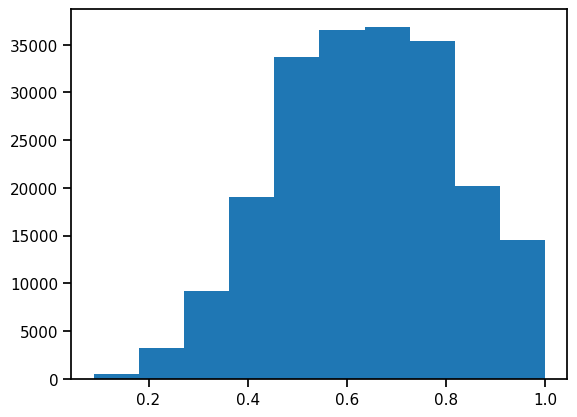

In [53]:
plt.hist(df['leaf_prob'])

<AxesSubplot: xlabel='leaf_prob', ylabel='Density'>

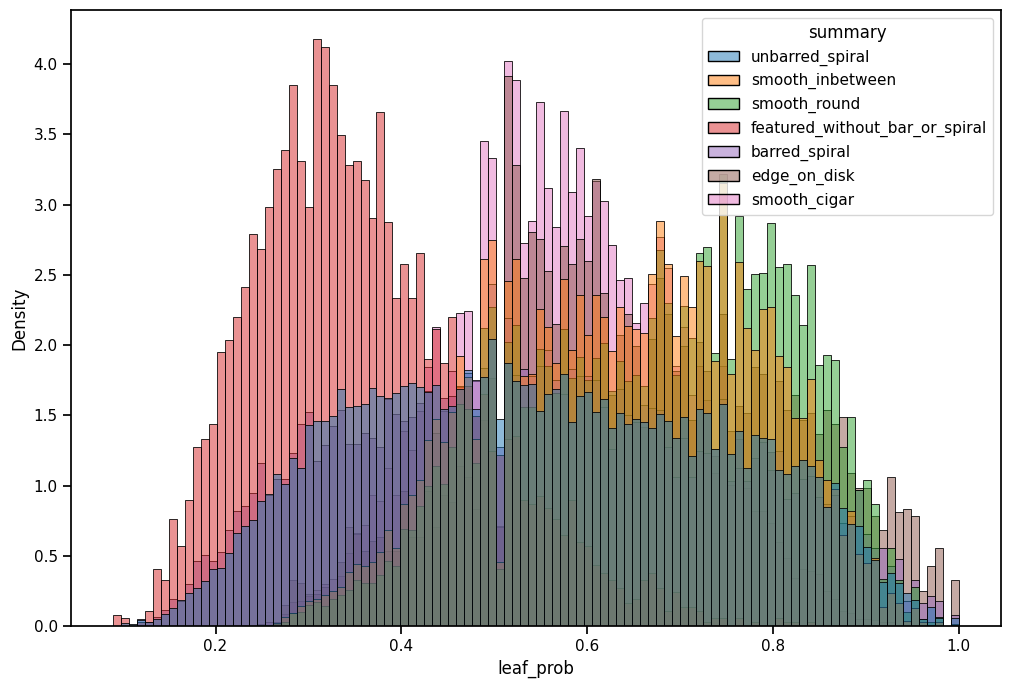

In [54]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(data=df, hue='summary', x='leaf_prob', ax=ax, stat='density', common_norm=False, common_bins=True)

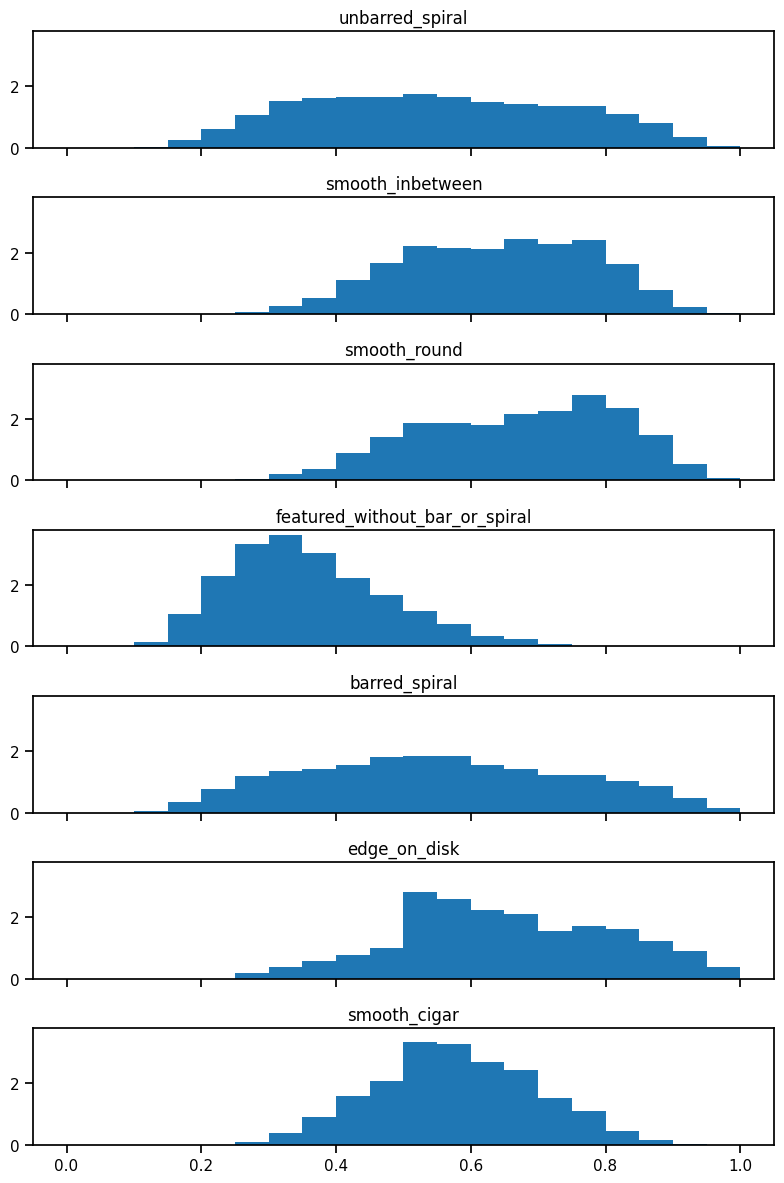

In [55]:
fig, axes = plt.subplots(figsize=(8, 12), nrows=7, sharex=True, sharey=True)
_, bins = np.histogram(np.linspace(0., 1.), bins=20)

for leaf_n, leaf in enumerate(df['summary'].dropna().unique()):
    
    ax = axes[leaf_n]

    leaf_probs = df.query(f'summary == "{leaf}"')['leaf_prob']
    ax.hist(leaf_probs, bins=bins, density=True)

    ax.set_title(leaf)

fig.tight_layout()

In [56]:


summary_to_class_index = {
    'smooth_inbetween': 0,
    'smooth_round': 1,
    'smooth_cigar': 2,
    'edge_on_disk': 3,
    'unbarred_spiral': 4,
    'barred_spiral': 5,
    'featured_without_bar_or_spiral': 6
}

df['label'] = df['summary'].apply(lambda x: summary_to_class_index.get(x, -1)).astype(int)  # be sure to drop -1's. Keeping here for dtype (nan is float)

df['label'].value_counts()

 0    78460
 1    54997
 4    26132
 2    19734
-1    11816
 5     9246
 3     4613
 6     4295
Name: label, dtype: int64

In [57]:
df.columns.values

array(['dr7objid', 'png_loc', 'ra', 'dec',
       'smooth-or-featured-gz2_smooth',
       'smooth-or-featured-gz2_featured-or-disk',
       'smooth-or-featured-gz2_artifact', 'disk-edge-on-gz2_yes',
       'disk-edge-on-gz2_no', 'bar-gz2_yes', 'bar-gz2_no',
       'has-spiral-arms-gz2_yes', 'has-spiral-arms-gz2_no',
       'bulge-size-gz2_no', 'bulge-size-gz2_just-noticeable',
       'bulge-size-gz2_obvious', 'bulge-size-gz2_dominant',
       'something-odd-gz2_yes', 'something-odd-gz2_no',
       'how-rounded-gz2_round', 'how-rounded-gz2_in-between',
       'how-rounded-gz2_cigar', 'bulge-shape-gz2_round',
       'bulge-shape-gz2_boxy', 'bulge-shape-gz2_no-bulge',
       'spiral-winding-gz2_tight', 'spiral-winding-gz2_medium',
       'spiral-winding-gz2_loose', 'spiral-arm-count-gz2_1',
       'spiral-arm-count-gz2_2', 'spiral-arm-count-gz2_3',
       'spiral-arm-count-gz2_4', 'spiral-arm-count-gz2_more-than-4',
       'spiral-arm-count-gz2_cant-tell',
       'smooth-or-featured-gz2_t

In [58]:
df.to_parquet('/home/walml/repos/galaxy-datasets/roots/gz2/gz2_with_leafs.parquet', index=False)

You can see how changing curation will change the class balance: first will drop misc-featured, then spirals, then smooth-cigar, then the rest